In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import mkl
mkl.set_num_threads(1)
print mkl.get_max_threads()

1


In [3]:
import numpy as np
import numpy.random as npr
import spglib as spg
import ase
from ase.io import read,write
from ase.spacegroup import crystal
from ase.visualize import view
import cPickle as pck
import pandas as pd
from tqdm import tqdm_notebook
import os,sys,psutil,signal
from quippy.potential import Potential, Minim
from ase.optimize import  FIRE
from ase.constraints import UnitCellFilter

In [4]:
from generate_and_relax_structures import generate_crystal_step_1,generate_crystal_step_1_wrapper
from libs.utils import unskewCell,ase2qp,qp2ase,get_standard_frame,isTooClose,isLayered
from libs.input_structure import input2crystal,getCellParam
from libs.LJ_pressure import (make_LJ_input,LJ_vcrelax,LJ_vcrelax_alternative,vc_relax_qp,AtomSeparator,
                              vc_relax_ase,get_LJ_parameters,make_LJ_input)
from libs.raw_data import z2symb,z2VdWradius,z2Covalentradius,SG2BravaisLattice,WyckTable,z2epsilon

/home/musil/miniconda/envs/glosim/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
import sys
sys.path.insert(0,'/local/git/glosim2/')
from libmatch.soap import get_Soaps
from libmatch.utils import get_soapSize,get_spkit,get_spkitMax,ase2qp,qp2ase
from libmatch.chemical_kernel import deltaKernel,PartialKernels
from GlobalSimilarity import get_environmentalKernels,get_globalKernel

In [6]:
d2r = np.pi/180.

# enthalpy

In [10]:
import sympy as sp

In [14]:
sp.init_printing() 

$H = U + pV$

perfect gaz -> $pV=cst$

$\Delta H_f = \int dU = \int_{\infty}^{r_m} F_{LJ}(r)dr = - \int_{\infty}^{r_m} \frac{V_{LJ}(r)}{dr}dr  $

$\Delta H_f = - (V_{LJ}(r_m) - V_{LJ}(\infty)) = - V_{LJ}(r_m) = -\epsilon\left(1^{12}-2*1^{6}\right) =   \epsilon$


In [5]:
print z2epsilon

{1: 2.2593901062472397, 2: 0.000470937100895, 3: 1.6510281925760115, 4: 3.3580234425274806, 5: 5.855812484654403, 6: 7.429834151989738, 7: 4.896495664159516, 8: 2.58307661900519, 9: 0.8222493512744372, 10: 0.0031738489227930004, 11: 1.1141590125669882, 12: 1.5245840999870135, 13: 3.4295369047294546, 14: 4.663921447954834, 15: 3.2802914183949, 16: 2.872664683843648, 17: 1.2572066655107053, 18: 0.01006590352343, 19: 0.9224200197066228, 20: 1.8427671854363767, 21: 3.915621162305192, 22: 4.9022996552947475, 23: 5.342781125379371, 24: 4.119589993629083, 25: 2.936197658234677, 26: 4.306354136944964, 27: 4.422433959649617, 28: 4.457672477256387, 29: 3.496904658977691, 30: 1.3515007929184675, 31: 2.8186668377462145, 32: 3.8555083969759965, 33: 3.135191640014083, 34: 2.354762117722974, 35: 1.1592435865638848, 36: 0.01418067874168, 37: 0.8384694336434358, 38: 1.6997402610324284, 39: 4.401705419880929, 40: 6.322204629449886, 41: 7.597009825224208, 42: 6.82984656838506, 43: 7.026974981585283, 44: 

# Func

In [7]:
def compare(frame1,frame2):
    centerweight  = 1.
    gaussian_width = 0.1
    cutoff = 3.5
    cutoff_transition_width = 0.5
    nmax = 8
    lmax = 6
    nocenters = []
    is_fast_average = False

    soap_params = {
              'centerweight': centerweight, 
              'gaussian_width': gaussian_width,'cutoff': cutoff, 
              'cutoff_transition_width': cutoff_transition_width,
              'nmax': nmax, 'lmax': lmax, 'is_fast_average':is_fast_average,
              'chem_channels': True ,'nocenters': nocenters,'dispbar':True,
                   }
    ff = []
    for frame in [frame1,frame2]:
        ff.append(ase2qp(frame))
     
    envk = get_environmentalKernels(ff,nthreads=1, nprocess=1, nchunks=1,**soap_params)
    gkern = get_globalKernel(envk, kernel_type='average', zeta=4, gamma=1.0, eps=1e-06, 
                             nthreads=8, normalize_global_kernel=True)
    
    return gkern[0,1]

In [8]:
def get_Nsoap(spkitMax,nmax,lmax):
    Nsoap = 0
    for sp1 in spkitMax:
        for sp2 in spkitMax:
            if sp1 == sp2:
                Nsoap += nmax*(nmax+1)*(lmax+1) / 2 
            elif sp1 > sp2:
                Nsoap += nmax**2*(lmax+1)
    return Nsoap + 1 
def get_fingerprints(frames,soap_params,nprocess):
    fings = get_Soaps(frames, nprocess=nprocess, **soap_params)
    N = len(frames)
    Nsoap = get_Nsoap(get_spkitMax(frames),soap_params['nmax'],soap_params['lmax'])
    soaps = np.zeros((N,Nsoap))
    ii = 0
    for iframe,fing in enumerate(fings):
        soaps[iframe] = fing['AVG']
        
    return soaps

In [9]:
def s2hms(time):
    m = time // 60
    s = int(time % 60)
    h = int(m // 60)
    m = int(m % 60)
    return '{:02d}:{:02d}:{:02d} (h:m:s)'.format(h,m,s)

def fpsSelection(data=None,distance_func=None,threshold=3e-3,Nmin=0,Nmax=20,seed=None):
    import numpy.random as npr
    from tqdm import tqdm_notebook
    nbOfFrames,Nfeature = data.shape 
    
    if seed is None:
        isel = 0
    else:
        npr.seed(seed)
        isel = npr.randint(0,nbOfFrames)    
    
    ldist = 1e100*np.ones(nbOfFrames,float)
    dsel = np.zeros(nbOfFrames,float)
    idx_to_compute = np.ones(nbOfFrames,bool)
    idx_to_ignore = np.zeros(nbOfFrames,bool)
    
    LandmarksIdx = []
    
    
    nsel = 0
    Nidx = 0
    cond = True
    pbar = tqdm_notebook(total=nbOfFrames)
    while cond:
        LandmarksIdx.append(isel)
        Nidx += 1
        idx_to_compute[isel] = False
        idx_to_ignore[isel] = True
        dsel.fill(0.)
        
        imax = 0       
        distLine = distance_func(data[isel,:].reshape((1,Nfeature)),
                                 data[idx_to_compute,:].reshape((-1,Nfeature)))
        
        dsel[idx_to_compute] = distLine.reshape((-1,))
        
        low = (dsel < ldist) * idx_to_compute
        ldist[low] = dsel[low]
        
        ldist[idx_to_ignore] = 0.
        isel = ldist.argmax()
        
        ids = (dsel < threshold) * idx_to_compute
        
        idx_to_compute[ids] = False
        idx_to_ignore[ids] = True
        
        if Nidx >= Nmin :
            if ldist[isel] < threshold:
                cond = False
            elif Nidx >= Nmax:
                cond = False
        pbar.update()
    pbar.close()
        
    return LandmarksIdx

def distance_func(XA,XB):
    #mkl.set_num_threads(10)
    kernel = np.dot(XB,XA.T)
    # the feature vectors are normalized
    dd = 2 - 2 * kernel
    dd[dd<0.] = 0.
    distance = np.sqrt(dd)
    return distance

def distance_func2(kernel):
    # the feature vectors are normalized
    dd = 2 - 2 * kernel
    dd[dd<0.] = 0.
    distance = np.sqrt(dd)
    return distance

def fpsSelection_with_restart(data=None,distance_func=None,restart_ref=None,disable_pbar=False,nthread=10,
                              intermediate_copy=True,stride=100,threshold=3e-3,Nmin=0,Nmax=20,seed=None,fn=None):
    import numpy.random as npr
    import cPickle as pck
    from tqdm import tqdm_notebook
    try:
        import mkl
        mkl.set_num_threads(nthread)
    except:
        pass
    
    if fn is None:
        fn = 'restart_ref_thr{}.pck'.format(threshold)
    
    nbOfFrames,Nfeature = data.shape 
    
    if nbOfFrames == Nfeature:
        iskernel = True
    else:
        iskernel = False
    
    if seed is None:
        isel = 0
    else:
        npr.seed(seed)
        isel = npr.randint(0,nbOfFrames)    
    
    dsel = np.zeros(nbOfFrames,float)
    idx_to_compute = np.ones(nbOfFrames,bool)
    idx_to_ignore = np.zeros(nbOfFrames,bool)
    
    if restart_ref is None:
        ldist = 1e100*np.ones(nbOfFrames,float)
        LandmarksIdx = []
        minmax = []
    else:
        LandmarksIdx = restart_ref['LandmarksIdx'][:-1]
        ldist = restart_ref['ldist']
        isel = restart_ref['LandmarksIdx'][-1]
        minmax = restart_ref['minmax']
        idx_to_compute[LandmarksIdx] = False
        idx_to_ignore[LandmarksIdx] = True
        
    Nidx = len(LandmarksIdx)
    cond = True
    pbar = tqdm_notebook(total=Nmax,disable=disable_pbar)
    
    while cond:
        
        LandmarksIdx.append(isel)
        
        if Nidx % (stride-1) == 0:
            with open(fn,'wb') as f:
                pck.dump({'LandmarksIdx':LandmarksIdx,'ldist':ldist,'minmax':minmax},f,protocol=pck.HIGHEST_PROTOCOL)
        
        Nidx += 1
        idx_to_compute[isel] = False
        idx_to_ignore[isel] = True
        dsel.fill(0.)
        
        imax = 0       
        if iskernel:
            distLine = distance_func(data[isel,idx_to_compute])
            dsel[idx_to_compute] = distLine
        else:
            if intermediate_copy:
                distLine = distance_func(data[isel,:].reshape((1,Nfeature)),
                                         data[idx_to_compute,:].reshape((-1,Nfeature)))
                dsel[idx_to_compute] = distLine.reshape((-1,))
            else:
                distLine = distance_func(data[isel,:].reshape((1,Nfeature)),data)
                dsel = distLine.reshape((-1,))
        
        
        low = (dsel < ldist) * idx_to_compute
        ldist[low] = dsel[low]
        
        ldist[idx_to_ignore] = 0.
        isel = ldist.argmax()
        minmax.append(ldist[isel])
        ids = (dsel < threshold) * idx_to_compute
        
        idx_to_compute[ids] = False
        idx_to_ignore[ids] = True
        
        if Nidx >= Nmin :
            if ldist[isel] < threshold:
                cond = False
            elif Nidx >= Nmax:
                cond = False
        
        pbar.update()
    pbar.close()
    return LandmarksIdx,minmax

# data

In [10]:
with open('./structures/structures_downsampled.pck','rb') as f:
    crystals = pck.load(f)

In [11]:
# view(crystals)

## downsample fps

In [10]:
with open('./structures/structures_141117.pck','rb') as f:
    crystals = pck.load(f)

In [ ]:
view(crystals)

In [12]:
soap_params = dict(nmax= 9, cutoff= 4, gaussian_width= 0.4, lmax= 9,
        centerweight = 1.,cutoff_transition_width = 0.5,
        nocenters = [],is_fast_average=True,chem_channels=False,dispbar=False
                      )
nprocess = 4

fings = get_fingerprints([ase2qp(crystal) for crystal in crystals],soap_params,nprocess)

HBox(children=(IntProgress(value=0, description=u'SOAP vectors', max=855), HTML(value=u'')))

In [13]:
kernel = np.dot(fings,fings.T)

In [14]:
fps_ids, minmax = fpsSelection_with_restart(data=kernel,distance_func=distance_func2,restart_ref=None,disable_pbar=False,nthread=10,
                              intermediate_copy=True,stride=10000,threshold=1e-9,Nmin=0,Nmax=kernel.shape[0],seed=None,
                                           fn=None)

HBox(children=(IntProgress(value=0, max=855), HTML(value=u'')))

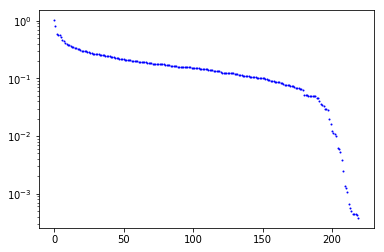

In [22]:
plt.plot(minmax[:220],'ob',ms=1)
plt.yscale('log')

In [23]:
ref_cc = [crystals[it] for it in fps_ids[:220]]

In [25]:
with open('./structures/structures_downsampled.pck','wb') as f:
    pck.dump(ref_cc,f,protocol=pck.HIGHEST_PROTOCOL)

# Make the batch crystal generation procedure

## tests on some MP structures

In [11]:
seed = 54565
np.random.seed(seed)

In [30]:
vdw_ratio = 1.5
sites_z = [14]
sg = 227 # 202
wycks = [8] # [0]
sg = 202
wycks = [0]
cc, sg, wyckoff_letters = input2crystal(sites_z ,seed ,vdw_ratio, sg=sg,wycks=wycks)
view(cc)
print sg,wyckoff_letters

202 ['i']


In [34]:
sym_data = spg.get_symmetry_dataset(cc)
print sym_data['number'],sym_data['wyckoffs'],sym_data['equivalent_atoms']

202 ['i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i'] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [35]:
dd = read('/home/musil/Downloads/'+'C_mp-667273_conventional_standard.cif')
sym_data = spg.get_symmetry_dataset(dd)
print sym_data['number'],sym_data['wyckoffs'],sym_data['equivalent_atoms']

202 ['i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'h', 'i', 'i', 'i', 'h', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'h', 'i', 'i', 'i', 'i', 'h', 'i', 'i', 'i', 'i', 'i', 'h', 'i', 'i', 'h', 'i', 'i', 'i', 'i', 'i', 'h', 'i', 'h', 'i', 'i', 'i', 'i', 'h', 'h', 'i', 'i', 'i', 'i', 'i', 'i', 'h', 'i', 'h', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'h', 'i', 'i', 'i', 'h', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'h', 'i', 'i', 'i', 'i', 'h', 'i', 'i', 'i', 'i', 'i', 'h', 'i', 'i', 'h', 'i', 'i', 'i', 'i', 'i', 'h', 'i', 'h', 'i', 'i', 'i', 'i', 'h', 'h', 'i', 'i', 'i', 'i', 'i', 'i', 'h', 'i', 'h', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'h', 'i', 'i', 'i', 'h', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'h', 'i', 'i', 'i', 'i', 'h', 'i', 'i', 'i', 'i', 'i', 'h', 'i', 'i', 'h', 'i', 'i', 'i', 'i', 'i', 'h', 'i', 'h', 'i', 'i', 'i', 'i', 'h', 'h', 'i', 'i', 'i', 'i', 'i', 'i', 'h', 'i', 'h', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'h', 'i', 'i', 'i', 'h', 'i', 'i', 'i', 'i', 'i', 'i', 

In [42]:
vdw_ratio = 10
sites_z = [14]
sg = 227 # 202
wycks = [8] # [0]
cc, sg, wyckoff_letters = input2crystal(sites_z ,seed ,vdw_ratio, sg=sg,wycks=wycks)
view(cc)
print sg,wyckoff_letters

[8]
227 ['a']


In [11]:
dd = read('/home/musil/Downloads/'+'C_mp-632329_symmetrized.cif')
sym_data = spg.get_symmetry_dataset(dd)
print sym_data['number'],sym_data['wyckoffs'],sym_data['equivalent_atoms']

12 ['i', 'i', 'i', 'i'] [0 0 0 0]


In [12]:
vdw_ratio = 1.5
sites_z = [14]
sg = 12 # 202
wycks = [1] # [0]
cc, sg, wyckoff_letters = input2crystal(sites_z ,vdw_ratio= vdw_ratio, sg=sg,wycks=wycks)
view(cc)
print sg,wyckoff_letters

12 ['i']


In [20]:
cc = new_crystals[55]
view(cc)

In [18]:
from quippy.potential import Potential
dd = ase2qp(cc)

LJ_parameters = get_LJ_parameters(dd)
max_cutoff = LJ_parameters['cutoffs'].max()
param_str = make_LJ_input(dd, LJ_parameters)
pot = Potential('IP LJ', param_str=param_str)
dd.set_calculator(pot)
dd.set_cutoff(max_cutoff, 0.5)

sep = AtomSeparator(dd)
sep.run(Nmax=20)

# ee = vc_relax_qp(dd,isotropic_external_pressure=1e-2, fmax=5e-3, steps=1e4)
ee = vc_relax_ase(dd, isotropic_external_pressure=1e-2,
                         fmax=5e-3, steps=5e5)
view(unskewCell(ee))

In [21]:
ee = LJ_vcrelax_alternative(cc,isotropic_external_pressure=1e-2,debug=False)
view(ee)

In [40]:
aspect_ratio = 0.75
length = ee.get_cell_lengths_and_angles()[:3]

rr = np.ones(3, int)

for it in range(3):
    mask = length / length[it] < aspect_ratio
    if np.any(mask):
        rr[it] = 2
print rr

[1 1 2]


In [32]:
view(dd)

## run

In [11]:
from libs.LJ_pressure import vc_relax_ase,vc_relax_qp,get_LJ_parameters,make_LJ_input,AtomSeparator
from libs.utils import stdchannel_to_null

In [14]:
np.random.seed(10)
sites_z = [14]
crystal, sg, wyckoff_letters = input2crystal(sites_z)
    
crystal = unskewCell(crystal)
dd = ase2qp(crystal)

# get the string to setup the quippy LJ potential (parameters and species)
LJ_parameters = get_LJ_parameters(dd)
max_cutoff = max(LJ_parameters['cutoffs'].values())*1.1
thr = min(LJ_parameters['cutoffs'].values())
param_str = make_LJ_input(dd, LJ_parameters)

pot = Potential('IP LJ', param_str=param_str)

sites_z = np.unique(crystal.get_atomic_numbers())
thr = np.min([z2Covalentradius[z] for z in sites_z])

dd.set_calculator(pot)
dd.set_cutoff(max_cutoff, 0.5)

sep = AtomSeparator(dd)
sep.run(Nmax=20)


In [15]:
vc_relax_ase(dd, fmax=5e-1, steps=1e4)

vc_relax_ase(dd, isotropic_external_pressure=20,
                             relax_positions=False,fmax=5e-5, steps=1e3)
view(dd)

In [120]:
for iii in range(100):
    if isLayered(dd,cutoff=thr*1.5, aspect_ratio=0.75):
        vc_relax_ase(dd, fmax=5e-1, steps=1e4)

        vc_relax_ase(dd, isotropic_external_pressure=20,
                     relax_positions=False,fmax=5e-5, steps=1e3)
    else:
        break
print iii
view(dd)

6


In [121]:
vc_relax_ase(dd, fmax=5e-4, steps=1e4)

<Atoms object at 0x7fadc31cdd50 fpointer=(1789871280, 22080)>

In [105]:
print dd.get_cell_lengths_and_angles()

[13.61955182 13.61955182 13.61955182 90.         90.         90.        ]


In [122]:
view(dd)

In [107]:
sg, wyckoff_letters

(229, ['l'])

In [108]:
data = spg.get_symmetry_dataset(dd)
print data['number'],data['wyckoffs'],data['equivalent_atoms']


229 ['l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l'] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [12]:
def generate_crystal(sites_z):
    crystal, sg, wyckoff_letters = input2crystal(sites_z)
    
    crystal = unskewCell(crystal)
    
    crystal = LJ_vcrelax_alternative(crystal, isotropic_external_pressure=20, debug=True)
    
#     thr = np.min([z2Covalentradius[z] for z in sites_z])

#     if isLayered(crystal,cutoff=thr*1.5, aspect_ratio=0.75):
#         crystal = LJ_vcrelax_alternative(crystal, isotropic_external_pressure=2, debug=True)
    
    return crystal


In [13]:
np.random.seed(10)
cc = generate_crystal([14])

In [126]:
print cc.get_cell_lengths_and_angles()
view(cc)

[13.53493621 13.53493621 13.53493621 90.         90.         90.        ]


In [14]:
data = spg.get_symmetry_dataset(cc)
print data['number'],data['wyckoffs'],data['equivalent_atoms']

229 ['l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l'] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [25]:
import multiprocessing as mp

def func_wrapper(inp):
    #np.random.rand()*
    current = mp.current_process()
    name = int(current._identity[0])
    
    return generate_crystal(**inp)
        
class mp_gen(object):
    def __init__(self, chunks, nprocess,dispbar=False):
        super(mp_gen, self).__init__()
        
            
        self.func_wrap = func_wrapper
        self.dispbar = dispbar
        self.parent_id = os.getpid()
        self.nprocess = nprocess

        
        self.chunks = chunks

    def run(self):
        Nit = len(self.chunks)
        pbar = tqdm_notebook(total=Nit,desc='',disable=self.dispbar)
        results = []
        if self.nprocess > 1:
            pool = mp.Pool(self.nprocess, initializer=self.worker_init,
                                maxtasksperchild=10)

            for res in pool.imap_unordered(self.func_wrap, self.chunks):
                results.append(res)
                pbar.update()

            pool.close()
            pool.join()

        elif self.nprocess == 1:
            for chunk in self.chunks:
                res = self.func_wrap(chunk)
                results.append(res)

                pbar.update()
        else:
            print 'Nproces: ',self.nprocess
            raise NotImplementedError('need at least 1 process')

        pbar.close()

        return results
    # clean kill of the pool in interactive sessions
    def worker_init(self):
        
        def sig_int(signal_num, frame):
            print('signal: %s' % signal_num)
            parent = psutil.Process(self.parent_id)
            for child in parent.children():
                if child.pid != os.getpid():
                    print("killing child: %s" % child.pid)
                    child.kill()
            print("killing parent: %s" % self.parent_id)
            parent.kill()
            print("suicide: %s" % os.getpid())
            psutil.Process(os.getpid()).kill()

        signal.signal(signal.SIGINT, sig_int)

In [26]:
sites_z = [14]
nprocess = 2
seed = 10
np.random.seed(seed)
pool = mp_gen([dict(sites_z=sites_z) for it in range(10)],nprocess=1,dispbar=False)

new_cc = pool.run()

HBox(children=(IntProgress(value=0, max=10), HTML(value=u'')))

In [27]:
view(new_cc)

In [19]:
view(new_cc[6])

In [21]:
cc = new_cc[6]
ncc = LJ_vcrelax_alternative(cc,isotropic_external_pressure=20,debug=False)


In [42]:
view(ncc)

In [25]:
thr = np.min([z2Covalentradius[z] for z in sites_z])
isLayered(ncc, cutoff=thr * 1.5, aspect_ratio=0.75,debug=True)

[1 1 1]
[1, 2, 3]
[2, 3]
[3]
[]
[]


False

In [43]:
aspect_ratio=0.75
crystal = ncc
length = crystal.get_cell_lengths_and_angles()[:3]
scaled = crystal.get_scaled_positions()
rr = np.ones(3, int)

for it in range(3):
    min,max = np.min(scaled[:,it]),np.max(scaled[:,it])
    mask2 = (max-min) < (1-aspect_ratio)
    mask = length / length[it] < aspect_ratio
    print mask,mask2
    if np.any(mask) or mask2:
        rr[it] = 2

[False False False] False
[False False False] False
[False False False] True


In [46]:
print  np.max(scaled[:,0])-np.min(scaled[:,0])

0.9999999999999175


In [36]:
def get_density(crystal):
    Na = crystal.get_number_of_atoms()
    V = crystal.get_volume()
    dens = float(Na)/V
    return dens

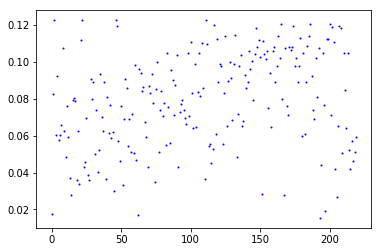

In [39]:
plt.plot([get_density(cc) for cc in crystals],'ob',ms=1)

In [41]:
view(crystals[it] for it in [0])

In [30]:
for it in range(3):
    print length / length[it]
    

[1.         1.         1.14006449]
[1.         1.         1.14006449]
[0.87714336 0.87714336 1.        ]


In [ ]:
#%%time

sites_z = [14]
nprocess = 1

pool = mp_gen([sites_z for it in range(500)],nprocess=nprocess,dispbar=False)

new_cc = pool.run()
# for it in tqdm_notebook(range(500)):
#     cc, sg, wyckoff_letters = input2crystal(sites_z)
#     ee = LJ_vcrelax_alternative(cc,isotropic_external_pressure=1e-2,debug=True)
#     new_cc.append(ee)

soap_params = dict(nmax= 9, cutoff= 4, gaussian_width= 0.4, lmax= 9,
        centerweight = 1.,cutoff_transition_width = 0.5,
        nocenters = [],is_fast_average=True,chem_channels=False,dispbar=True
                      )


new_crystals = []
new_crystals.extend(crystals)
new_crystals.extend(new_cc)

fings = get_fingerprints([ase2qp(crystal) for crystal in new_crystals],soap_params,nprocess)
kernel = np.dot(fings,fings.T)

fps_ids, minmax = fpsSelection_with_restart(data=kernel,distance_func=distance_func2,restart_ref=None,
                                            disable_pbar=True,nthread=10,
                              intermediate_copy=True,stride=10000,threshold=5e-3,Nmin=0,
                                            Nmax=kernel.shape[0],seed=None,fn=None)

new_crystals = [new_crystals[it] for it in fps_ids]


HBox(children=(IntProgress(value=0, max=500), HTML(value=u'')))

signal: 2
killing child: 29580
killing child: 29582
killing child: 29583


In [36]:
from libs.io import Frame_Dataset_h5
from glob import glob

In [53]:
fns = glob('./structures/relaxed_structures_r*')
readers = []
for fn in fns:
    readers.append(Frame_Dataset_h5(fn,mode='r',disable_pbar=True))

In [54]:
frames = []
for reader in readers:
    frames.extend(reader.load_frames().values())
#view(frames)

In [55]:
inputs = []
for reader in readers:
    inputs.extend(reader.get_inputs().values())
#view([cc for (cc,_) in inputs])

In [24]:
cc = crystals[5]
sym_data = spg.get_symmetry_dataset(cc)
print sym_data['number'],sym_data['wyckoffs'],sym_data['equivalent_atoms']

227 ['b', 'b', 'b', 'b', 'b', 'b', 'b', 'b'] [0 0 0 0 0 0 0 0]


In [25]:
view(get_standard_frame(cc,to_primitive=True,symprec=1e-5))

In [56]:
new_crystals = []
new_crystals.extend(frames)
new_crystals.extend(crystals)

In [57]:
soap_params = dict(nmax= 9, cutoff= 4, gaussian_width= 0.4, lmax= 9,
        centerweight = 1.,cutoff_transition_width = 0.5,
        nocenters = [],is_fast_average=True,chem_channels=False,dispbar=False
                      )
nprocess = 4

fings = get_fingerprints([ase2qp(crystal) for crystal in new_crystals],soap_params,nprocess)

HBox(children=(IntProgress(value=0, description=u'SOAP vectors', max=10217), HTML(value=u'')))

In [59]:
kernel = np.dot(fings,fings.T)

In [60]:
fps_ids, minmax = fpsSelection_with_restart(data=kernel,distance_func=distance_func2,restart_ref=None,disable_pbar=False,nthread=10,
                              intermediate_copy=True,stride=10000,threshold=1e-9,Nmin=0,Nmax=kernel.shape[0],seed=None,
                                           fn=None)

HBox(children=(IntProgress(value=0, max=10217), HTML(value=u'')))

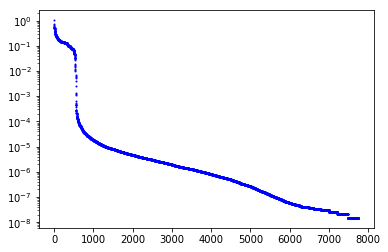

In [61]:
plt.plot(minmax[:],'ob',ms=1)
plt.yscale('log')

In [68]:
minmax = np.array(minmax)

In [81]:
minmax[minmax > 1e-3].shape

(554,)

In [62]:
from sklearn.manifold import TSNE
import hdbscan

In [71]:
distance = distance_func2(kernel)

In [72]:
tsne = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, 
     learning_rate=200.0, n_iter=1000, metric='precomputed')

In [73]:
X = tsne.fit_transform(distance)

In [74]:
clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40, 
    metric='precomputed', min_cluster_size=10, min_samples=None, p=None)
clusterer.fit(distance)
print len(np.unique(clusterer.labels_))

191


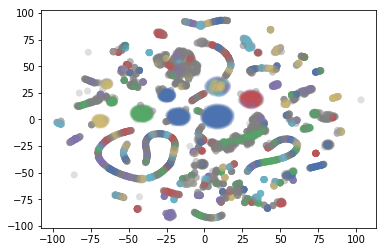

In [76]:
color_palette = sns.color_palette('deep', len(np.unique(clusterer.labels_)))
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*X.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)